In [ ]:
# Cell 1: Setup
import data_loader
import importlib
importlib.reload(data_loader)

print(f"Box size1: {BOX_SIZE}")

# Setup
from data_loader import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

print("BOX_SIZE2:", BOX_SIZE)


Loading bubble data...
✓ Loaded 634277 observations
✓ Timesteps added: 0 to 3426
✓ Identified 300 disappearing bubbles
Applying periodic boundary corrections...
✓ Periodic boundary correction applied
✓ Derived quantities computed

DATA LOADING COMPLETE
Total observations:       634,277
Unique bubbles:           400
Timesteps:                0 to 3426
Disappearing bubbles:     300
Box size:                 22.36068
Initial avg area (A_0):   1.000000

Available variables:
  - df: Original dataframe
  - df_corrected: Corrected dataframe with actual_area column
  - disappearing_ids: Set of disappearing bubble IDs
  - bubbles_per_timestep: Number of bubbles at each timestep
  - avg_area_per_timestep: Average bubble area at each timestep
  - approx_avg_area: Approximate area from liquid fraction
  - A_0: Initial average bubble area
  - max_timestep: Maximum timestep
  - final_step: Final timestep
  - box_area: Total box area
  - BOX_SIZE, PERIODIC_THRESHOLD, LIQUID_FRACTION: Constants

BOX_S

In [3]:
# Mean squared displacement analysis

# Reuse variables from last cell
max_timestep = df_corrected["timestep"].max()
print(f"Maximum timestep: {max_timestep}")

initial_bubble_count = bubbles_per_timestep.iloc[0]
print(f"Initial number of bubbles: {initial_bubble_count}")

# Find timesteps where significant bubble losses occur
milestone_counts = [300, 200, 125]
milestone_timesteps = {}

for count in milestone_counts:
    mask = bubbles_per_timestep <= count
    if mask.any():
        milestone_timesteps[count] = bubbles_per_timestep[mask].index[0]
    else:
        milestone_timesteps[count] = None

print("Milestone timesteps:")
for count, timestep in milestone_timesteps.items():
    if timestep is not None:
        print(f"  {count} bubbles left at timestep {timestep}")
    else:
        print(f"  Never reached {count} bubbles")

# A_0 initial average bubble area 
print(f"Initial average bubble area <A_0>: {A_0:.6f}")

Maximum timestep: 3426
Initial number of bubbles: 400
Milestone timesteps:
  300 bubbles left at timestep 342
  200 bubbles left at timestep 1246
  125 bubbles left at timestep 2475
Initial average bubble area <A_0>: 1.000000


In [4]:

# Calculate MSD for each timestep
timesteps = np.arange(0, max_timestep + 1)
msd_values = []
bubble_counts = []

for t in timesteps:
    # Get all bubbles that exist at timestep t
    bubbles_at_t = df_corrected[df_corrected["timestep"] == t]
    
    if len(bubbles_at_t) == 0:
        msd_values.append(np.nan)
        bubble_counts.append(0)
        continue
    
    # Calculate squared displacement from initial position for each bubble
    squared_displacements = []
    
    for bubble_id in bubbles_at_t["id"].unique():
        # Get all positions for this bubble up to timestep t
        bubble_data = df_corrected[
            (df_corrected["id"] == bubble_id) & 
            (df_corrected["timestep"] <= t)
        ].sort_values("timestep")
        
        if len(bubble_data) < 2:  # Need at least initial position
            continue
            
        # Get initial and current positions
        x_initial = bubble_data["x"].iloc[0]
        y_initial = bubble_data["y"].iloc[0]
        x_current = bubble_data["x"].iloc[-1]
        y_current = bubble_data["y"].iloc[-1]
        
        # Calculate squared displacement from initial position
        dx = x_current - x_initial
        dy = y_current - y_initial
        r_squared = dx**2 + dy**2
        
        squared_displacements.append(r_squared)
    
    if squared_displacements: # only if we have valid displacements
        msd_values.append(np.mean(squared_displacements))
        bubble_counts.append(len(squared_displacements))
    else:
        msd_values.append(np.nan) # no valid bubbles
        bubble_counts.append(0)

msd_values = np.array(msd_values)
bubble_counts = np.array(bubble_counts)

# Remove NaN values for plotting
valid_mask = ~np.isnan(msd_values)
timesteps_valid = timesteps[valid_mask]
msd_valid = msd_values[valid_mask]
counts_valid = bubble_counts[valid_mask]

print(f"Valid timesteps for MSD: {len(timesteps_valid)}")


Valid timesteps for MSD: 3426


Slope of averaged MSD: 0.0008044581113997386


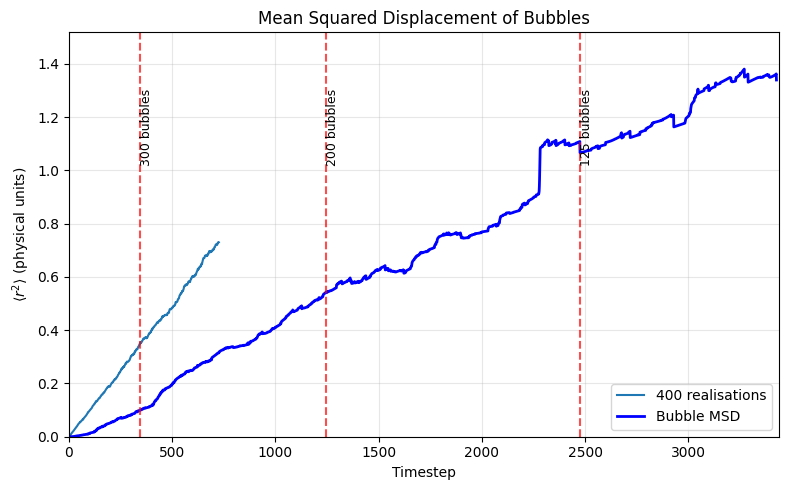

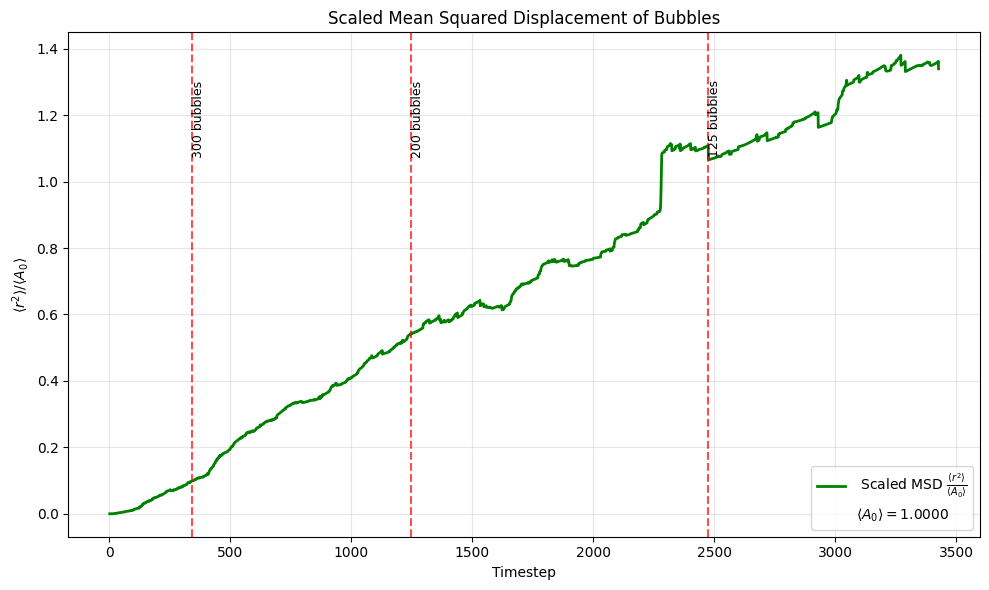

<Figure size 800x500 with 0 Axes>

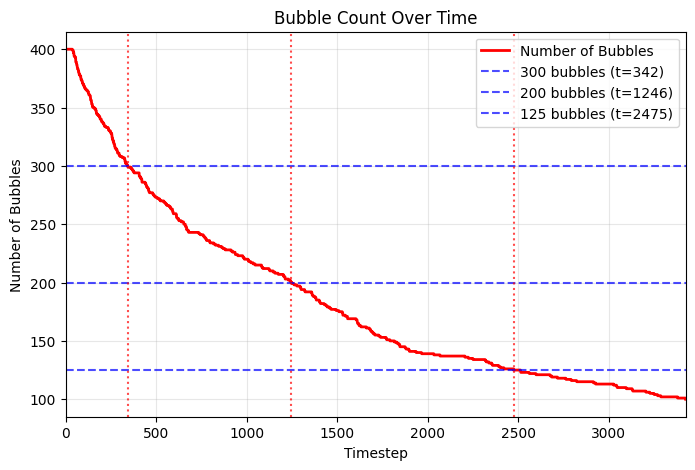

In [ ]:
num_steps = 726
num_walks = 400
std_dev = 0.02 # worth noting it is too random to analyse properly with std_dev over 0.5
box_size = 20.203051
scale = 0.5 # scaling for start and end points

# Store squared displacements
squared_displacements = np.zeros((num_walks, num_steps+1))

grid_size = int(np.sqrt(num_walks))                 # 20 x 20 grid = 400 walks
x_grid = np.linspace(0, box_size, grid_size)
y_grid = np.linspace(0, box_size, grid_size)
start_positions = np.array([(x, y) for x in x_grid for y in y_grid])

for w in range(num_walks):
    steps_x = np.random.normal(0, std_dev, num_steps) # when choosing these steps we are in tern choosing velocities
    steps_y = np.random.normal(0, std_dev, num_steps)

    x_positions = np.insert(np.cumsum(steps_x), 0, 0)
    y_positions = np.insert(np.cumsum(steps_y), 0, 0)

    squared_displacements[w] = x_positions**2 + y_positions**2

    x_positions += start_positions[w, 0]
    y_positions += start_positions[w, 1]

# Average over walks
msd = squared_displacements.mean(axis=0)
slope = (msd[-1] - msd[0]) / (num_steps - 0)
print(f"Slope of averaged MSD: {slope}")

plt.figure(figsize=(8, 5))  # Create new figure with specific size
plt.plot((msd/std_dev**2)/2000, label=r"400 realisations")            # msd/(v0**2 t0**2)

# Plot MSD with different scaling options

# Plot 1: MSD in physical units
plt.plot(timesteps_valid, msd_valid, 'b-', linewidth=2, label='Bubble MSD')
plt.xlabel('Timestep')
plt.ylabel(r'$\langle r^2 \rangle$ (physical units)')
plt.title('Mean Squared Displacement of Bubbles')
plt.grid(True, alpha=0.3)

# Add vertical lines for milestone bubble counts
for count, timestep in milestone_timesteps.items():
    if timestep is not None and timestep <= max_timestep:
        plt.axvline(x=timestep, color='red', linestyle='--', alpha=0.7)
        plt.text(timestep, plt.gca().get_ylim()[1] * 0.9, f'{count} bubbles', 
                 rotation=90, verticalalignment='top', fontsize=9)

plt.legend()
plt.tight_layout()
plt.xlim(0, max_timestep+10)
plt.ylim(0, msd_valid.max()*1.1)
# plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/06_Figures/bubble_MSD_alongside_Gaussian400_2.png", dpi=300, bbox_inches='tight')
plt.show()


# Plot 2: MSD scaled by initial average bubble area

plt.figure(figsize=(10, 6))
msd_scaled = msd_valid / A_0
plt.plot(timesteps_valid, msd_scaled, 'g-', linewidth=2, 
         label=r' Scaled MSD $\frac{\langle r^2 \rangle}{\langle A_0 \rangle}$')
plt.plot([], [], ' ', label=fr'$\langle A_0 \rangle={A_0:.4f}$')  # Empty plot for A0 value in legend
plt.xlabel('Timestep')
plt.ylabel(r'$\langle r^2 \rangle / \langle A_0 \rangle$')
plt.title('Scaled Mean Squared Displacement of Bubbles')
plt.grid(True, alpha=0.3)

# Add vertical lines for milestone bubble counts
for count, timestep in milestone_timesteps.items():
    if timestep is not None and timestep <= max_timestep:
        plt.axvline(x=timestep, color='red', linestyle='--', alpha=0.7)
        plt.text(timestep, plt.gca().get_ylim()[1] * 0.9, f'{count} bubbles', 
                 rotation=90, verticalalignment='top', fontsize=9)

plt.legend()
plt.tight_layout()
plt.figure(figsize=(8,5))
# plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/06_Figures/bubble_MSD_analysis_2.png", dpi=300)
plt.show()



# Plot 3: Bubble count vs timestep to visualize disappearance

plt.figure(figsize=(8, 5))
plt.plot(timesteps_valid, counts_valid, 'r-', linewidth=2, label='Number of Bubbles')
plt.xlabel('Timestep')
plt.ylabel('Number of Bubbles')
plt.title('Bubble Count Over Time')
plt.grid(True, alpha=0.3)

# Add horizontal lines for milestones with timestep information in label
for count, timestep in milestone_timesteps.items():
    if timestep is not None:
        plt.axhline(y=count, color='blue', linestyle='--', alpha=0.7, 
                   label=f'{count} bubbles (t={timestep})')
    
# Add vertical lines at milestone timesteps
for count, timestep in milestone_timesteps.items():
    if timestep is not None:
        plt.axvline(x=timestep, color='red', linestyle=':', alpha=0.7)

plt.legend()
plt.xlim(0, max_timestep)
# plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/06_Figures/bubble(MSD)_count_over_time_2.png", dpi=300)
plt.show()



MSD Analysis Results:
MSD slope (early timesteps): 4.551263e-04
Effective diffusion coefficient: 1.137816e-04
R-squared: 0.9880


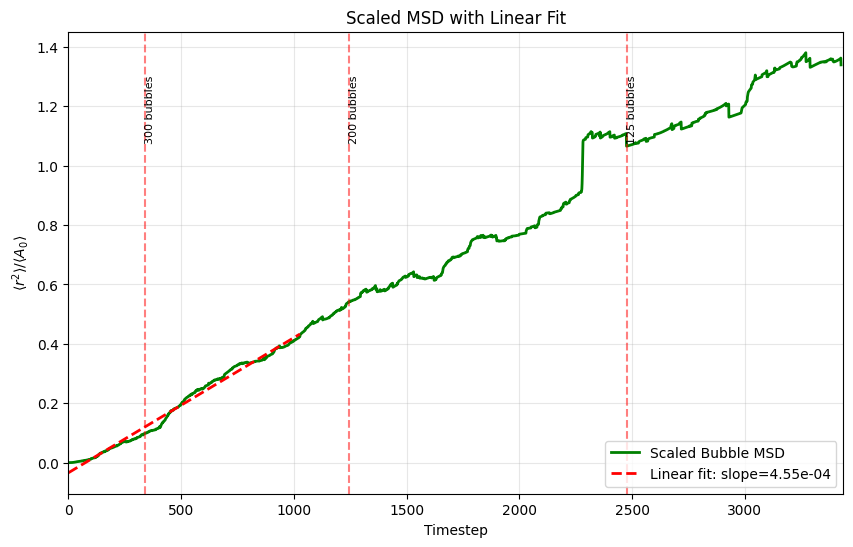

In [ ]:
# Calculate effective diffusion coefficient from MSD slope

# For the early part of the simulation where bubble count is higher 
if len(timesteps_valid) > 10:
    # Use first 30% of data for linear fit
    fit_end = int(0.3 * len(timesteps_valid))
    t_fit = timesteps_valid[:fit_end]
    msd_fit = msd_valid[:fit_end]
    
    if len(t_fit) > 5:
        slope_msd, intercept_msd, r_value, p_value, std_err = linregress(t_fit, msd_fit)
        D_eff = slope_msd / 4  # In 2D, MSD = 4*D*t
        
        print(f"\nMSD Analysis Results:")
        print(f"MSD slope (early timesteps): {slope_msd:.6e}")
        print(f"Effective diffusion coefficient: {D_eff:.6e}")
        print(f"R-squared: {r_value**2:.4f}")
        
        # Add fitted line to scaled plot
        plt.figure(figsize=(10, 6))
        plt.plot(timesteps_valid, msd_scaled, 'g-', linewidth=2, label='Scaled Bubble MSD')
        
        # Plot fitted line
        msd_fit_scaled = msd_fit / A_0
        plt.plot(t_fit, (intercept_msd + slope_msd * t_fit) / A_0, 'r--', linewidth=2, 
                label=f'Linear fit: slope={slope_msd/A_0:.2e}')
        
        plt.xlabel('Timestep')
        plt.ylabel(r'$\langle r^2 \rangle / \langle A_0 \rangle$')
        plt.title('Scaled MSD with Linear Fit')
        plt.grid(True, alpha=0.3)
        
        # Add milestone lines
        for count, timestep in milestone_timesteps.items():
            if timestep is not None and timestep <= max_timestep:
                plt.axvline(x=timestep, color='red', linestyle='--', alpha=0.5)
                plt.text(timestep, plt.gca().get_ylim()[1] * 0.9, f'{count} bubbles', 
                        rotation=90, verticalalignment='top', fontsize=8)
        
        plt.legend()
        plt.xlim(0, max_timestep+10)
        # plt.savefig("/Users/conorkirby/Library/Mobile Documents/com~apple~CloudDocs/Coding/projects/python/capstone/Figures_Sample2/06_Figures/bubble_MSD_scaled_with_fit_2.png", dpi=300)
        plt.show()